# Forecasting Model Script (Example)

##### This script is to provide rerefernce as practical guide accompanied to the forecast overview/research.

#### ___________________________________________________________________

### Script Goal:
### M5 Forecasting - Accuracy (Estimate the unit sales of Walmart retail goods)

Hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.

link: https://www.kaggle.com/c/m5-forecasting-accuracy

#### ___________________________________________________________________

### Dataset Description:
#### The dataset consists of five .csv files.
 1. calendar.csv - Contains the dates on which products are sold. The dates are in a yyyy/dd/mm format.

 2. sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913].

 3. sample_submission.csv - Demonstrates the correct format for submission to the competition.

 4. sell_prices.csv - Contains information about the price of the products sold per store and date.

 5. sales_train_evaluation.csv - Available one month before the competition deadline. It will include sales for [d_1 - d_1941].

#### In this competition, we need to forecast the sales for [d_1942 - d_1969]. These rows form the evaluation set. The rows [d_1914 - d_1941] form the validation set, and the remaining rows form the training set.

#### ___________________________________________________________________

### Import Libraries:

In [1]:
# Library Imports
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import DMatrix
import joblib
from lightgbm import Dataset,train,plot_importance
from xgboost import train as train2
import matplotlib.pyplot as plt
import shap

import warnings
warnings.filterwarnings('ignore')

#### ___________________________________________________________________

### Reading Data

In [2]:
# Sales Evaluation
sales_train_validation = pd.read_csv("C:/Users/muham/OneDrive/Desktop/_/Year 3_Semester 1/MP/Data/sales_train_evaluation.csv")

# Price Features
sell_prices = pd.read_csv("C:/Users/muham/OneDrive/Desktop/_/Year 3_Semester 1/MP/Data/sell_prices.csv")

# Calendar Features
calendar = pd.read_csv("C:/Users/muham/OneDrive/Desktop/_/Year 3_Semester 1/MP/Data/calendar.csv")

# Submission Output
submission = pd.read_csv('C:/Users/muham/OneDrive/Desktop/_/Year 3_Semester 1/MP/Data/sample_submission.csv')

#### ___________________________________________________________________

### Downcasting (Reduce Memory Load)

In [3]:
# Measure memory allocation before downcast
sales_bd = np.round(sales_train_validation.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(sell_prices.memory_usage().sum()/(1024*1024),1)
submission_bd = np.round(submission.memory_usage().sum()/(1024*1024),1)

In [4]:
# Downcast in order to save memory
def downcast(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)  
    return df  

sales_train_validation = downcast(sales_train_validation)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)
submission = downcast(submission)

In [5]:
# Measure memory allocation after downcast
sales_ad = np.round(sales_train_validation.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(sell_prices.memory_usage().sum()/(1024*1024),1)
submission_ad = np.round(submission.memory_usage().sum()/(1024*1024),1)

Visualizing downcasting

In [6]:
# Comparing before and after memory allocation with barplots
dic = {'DataFrame':['sales','calendar','prices','submission'],
       'Before downcasting':[sales_bd,calendar_bd,prices_bd,submission_ad],
       'After downcasting':[sales_ad,calendar_ad,prices_ad,submission_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Effect of Downcasting')
fig.show()

#### ___________________________________________________________________

### Data Validation

Sales Evaluation.csv

In [7]:
# Check Sales Evaluation Shape
sales_train_validation.shape

(30490, 1947)

In [8]:
# Check Sales Evaluation Output
sales_train_validation.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0       CA    0    0    0    0  ...       2       4       0       0       0   
1       CA    0    0    0    0  ...       0       1       2       1       1   
2       CA    0    0    0    0  ...       1       0       2       0       0   
3       CA    0    0    0    0  ...       1       1       0       4       0   
4       CA    0    0    0    0  ...       0       0       0       2       1   

   d_1937  d_1938  d_1939  d_1940  d_1941  
0       0       3       3       0       1  
1       0       0       0       0       0  
2       0       2       3       0       1  
3       1       3       0       2       6  
4       0       0       2       1       0  

[5 rows x 1947 columns]

In [9]:
# Check Nul Values
check = sales_train_validation.isna().sum().sum()
check

0

In [10]:
# Check data types for respective columns
sales_train_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int16(1317), int8(624), object(6)
memory usage: 96.1+ MB


In [11]:
# Int16 datatypes
sales_train_validation.select_dtypes(include='int16')

d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  ...  d_1918  d_1919  \
0        0    0    0    0    0    0    0    0    0     0  ...       0       3   
1        0    0    0    0    0    0    0    0    0     0  ...       0       0   
2        0    0    0    0    0    0    0    0    0     0  ...       0       2   
3        0    0    0    0    0    0    0    0    0     0  ...       4       1   
4        0    0    0    0    0    0    0    0    0     0  ...       1       0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...     ...     ...   
30485    0    0    2    2    0    3    1    4    1     0  ...       2       0   
30486    0    0    0    0    0    5    0    1    1     3  ...       0       0   
30487    0    6    0    2    2    4    1    8    5     2  ...       0       2   
30488    0    0    0    0    0    0    0    0    0     0  ...       2       1   
30489    0    0    0    0    0    0    0    0    0     0  ...       0       1   

       d_1922  d_1925  d_1926  d_1927  d_1932  d_1933  d_1934  d_1940  
0           0       0       2       1       2       4       0       0  
1           0       0       0       0       0       1       2       0  
2           0       2       1       3       1       0       2       0  
3           0       2       2       4       1       1       0       2  
4           3       3       2       3       0       0       0       1  
...       ...     ...     ...     ...     ...     ...     ...     ...  
30485       2       1       1       1       1       0       3       1  
30486       1       0       0       0       0       0       0       1  
30487       0       0       0       1       0       0       1       0  
30488       1       0       2       1       1       1       1       1  
30489       2       3       2       1       1       2       0       5  

[30490 rows x 1317 columns]

In [12]:
# Int8 datatypes
sales_train_validation.select_dtypes(include='int8')

d_14  d_17  d_18  d_19  d_20  d_21  d_23  d_24  d_26  d_27  ...  \
0         0     0     0     0     0     0     0     0     0     0  ...   
1         0     0     0     0     0     0     0     0     0     0  ...   
2         0     0     0     0     0     0     0     0     0     0  ...   
3         0     0     0     0     0     0     0     0     0     0  ...   
4         0     0     0     0     0     0     0     0     0     0  ...   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
30485     4     1     0     1     1     7     3     6     3     7  ...   
30486     4     1     2     1     1     0     0     0     1     1  ...   
30487     5    10     3     3     4     7     3     5     3     4  ...   
30488     0     0     0     0     0     0     0     0     0     0  ...   
30489     0     0     0     0     0     0     0     0     0     0  ...   

       d_1928  d_1929  d_1930  d_1931  d_1935  d_1936  d_1937  d_1938  d_1939  \
0           2       2       1       0       0       0       0       3       3   
1           0       0       0       0       1       1       0       0       0   
2           0       0       1       0       0       0       0       2       3   
3           2       1       1       1       4       0       1       3       0   
4           2       2       2       2       2       1       0       0       2   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
30485       0       0       1       0       0       1       1       0       0   
30486       0       0       0       0       0       0       0       1       0   
30487       0       3       3       1       2       0       1       0       1   
30488       1       0       2       1       4       6       0       1       1   
30489       1       0       0       0       5       4       0       2       2   

       d_1941  
0           1  
1           0  
2           1  
3           6  
4           0  
...       ...  
30485       1  
30486       0  
30487       2  
30488       0  
30489       1  

[30490 rows x 624 columns]

In [13]:
# Object datatypes
sales_train_validation.select_dtypes(include='object')

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  
0         CA_1       CA  
1         CA_1       CA  
2         CA_1       CA  
3         CA_1       CA  
4         CA_1       CA  
...        ...      ...  
30485     WI_3       WI  
30486     WI_3       WI  
30487     WI_3       WI  
30488     WI_3       WI  
30489     WI_3       WI  

[30490 rows x 6 columns]

Calendar.csv

In [14]:
# Check Calender shape
calendar.shape

(1969, 14)

In [15]:
# Check Calender output
calendar.head(5)

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [16]:
# Check data types & null values for respective columns
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int16 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int8  
 4   month         1969 non-null   int8  
 5   year          1969 non-null   int16 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int8  
 12  snap_TX       1969 non-null   int8  
 13  snap_WI       1969 non-null   int8  
dtypes: int16(2), int8(5), object(7)
memory usage: 125.1+ KB


Sell Prices.csv

In [17]:
# Check Sell Prices shape
sell_prices.shape

(6841121, 4)

In [18]:
# Check Sell Prices output
sell_prices.head(5)

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325    9.578125
1     CA_1  HOBBIES_1_001     11326    9.578125
2     CA_1  HOBBIES_1_001     11327    8.257812
3     CA_1  HOBBIES_1_001     11328    8.257812
4     CA_1  HOBBIES_1_001     11329    8.257812

In [19]:
# Check Sell Prices data types for respective columns
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int16  
 3   sell_price  float16
dtypes: float16(1), int16(1), object(2)
memory usage: 130.5+ MB


In [20]:
# Check null values for Sell Prices
sell_prices.isna().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

Submission.csv

In [21]:
# Check Submission shape
submission.shape

(60980, 29)

In [22]:
submission.head()

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  \
0  HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
1  HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
2  HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
3  HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
4  HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   

   F19  F20  F21  F22  F23  F24  F25  F26  F27  F28  
0    0    0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0    0    0  

[5 rows x 29 columns]

#### ___________________________________________________________________

### Melting Data

In [23]:
# Melting data into a more redeabale and predictable format
sales_train_validation = pd.melt(sales_train_validation,
                                 id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                                 var_name = 'day',
                                 value_name = 'demand')
                                 
print('Melted sales data has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))

Melted sales data has 59181090 rows and 8 columns


In [24]:
# View new data structure
sales_train_validation

id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
59181085    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
59181086    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
59181087    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
59181088    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
59181089    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id     day  demand  
0            CA_1       CA     d_1       0  
1            CA_1       CA     d_1       0  
2            CA_1       CA     d_1       0  
3            CA_1       CA     d_1       0  
4            CA_1       CA     d_1       0  
...           ...      ...     ...     ...  
59181085     WI_3       WI  d_1941       1  
59181086     WI_3       WI  d_1941       0  
59181087     WI_3       WI  d_1941       2  
59181088     WI_3       WI  d_1941       0  
59181089     WI_3       WI  d_1941       1  

[59181090 rows x 8 columns]

#### ___________________________________________________________________

### Preparing Test Set d_1942 - d_1969 (Not given in data)

In [25]:
# Preping Test data for +28 days since it is not included in the data
test2_rows = [row for row in submission['id'] if 'evaluation' in row]
test2 = submission[submission['id'].isin(test2_rows)]

test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                  'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']

product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()


test2 = test2.merge(product, how = 'left', on = 'id')

test2 = pd.melt(test2, 
                id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', 
                value_name = 'demand')

sales_train_validation['part'] = 'train'
test2['part'] = 'test'

#### ___________________________________________________________________

### Merging

In [26]:
# Concat Train and Test data 
data = pd.concat([sales_train_validation,test2], axis = 0)
del sales_train_validation,test2

gc.collect()

data.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  day  demand   part  
0       CA  d_1       0  train  
1       CA  d_1       0  train  
2       CA  d_1       0  train  
3       CA  d_1       0  train  
4       CA  d_1       0  train

In [27]:
# Merging Calendar data 
data.reset_index(drop=True,inplace=True)
data = data.loc[30000000:]
calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d', 'day'], inplace = True, axis = 1)

data.head()

id          item_id      dept_id     cat_id  \
0  HOUSEHOLD_1_331_WI_3_evaluation  HOUSEHOLD_1_331  HOUSEHOLD_1  HOUSEHOLD   
1  HOUSEHOLD_1_332_WI_3_evaluation  HOUSEHOLD_1_332  HOUSEHOLD_1  HOUSEHOLD   
2  HOUSEHOLD_1_333_WI_3_evaluation  HOUSEHOLD_1_333  HOUSEHOLD_1  HOUSEHOLD   
3  HOUSEHOLD_1_334_WI_3_evaluation  HOUSEHOLD_1_334  HOUSEHOLD_1  HOUSEHOLD   
4  HOUSEHOLD_1_335_WI_3_evaluation  HOUSEHOLD_1_335  HOUSEHOLD_1  HOUSEHOLD   

  store_id state_id  demand   part        date  wm_yr_wk event_name_1  \
0     WI_3       WI       0  train  2013-10-08     11337          NaN   
1     WI_3       WI       0  train  2013-10-08     11337          NaN   
2     WI_3       WI       0  train  2013-10-08     11337          NaN   
3     WI_3       WI      11  train  2013-10-08     11337          NaN   
4     WI_3       WI       0  train  2013-10-08     11337          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        1        0        1  
1          NaN          NaN          NaN        1        0        1  
2          NaN          NaN          NaN        1        0        1  
3          NaN          NaN          NaN        1        0        1  
4          NaN          NaN          NaN        1        0        1

In [28]:
# Merging Price data
data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')

del calendar,sell_prices,product
gc.collect()

data.head()

id          item_id      dept_id     cat_id  \
0  HOUSEHOLD_1_331_WI_3_evaluation  HOUSEHOLD_1_331  HOUSEHOLD_1  HOUSEHOLD   
1  HOUSEHOLD_1_332_WI_3_evaluation  HOUSEHOLD_1_332  HOUSEHOLD_1  HOUSEHOLD   
2  HOUSEHOLD_1_333_WI_3_evaluation  HOUSEHOLD_1_333  HOUSEHOLD_1  HOUSEHOLD   
3  HOUSEHOLD_1_334_WI_3_evaluation  HOUSEHOLD_1_334  HOUSEHOLD_1  HOUSEHOLD   
4  HOUSEHOLD_1_335_WI_3_evaluation  HOUSEHOLD_1_335  HOUSEHOLD_1  HOUSEHOLD   

  store_id state_id  demand   part        date  wm_yr_wk event_name_1  \
0     WI_3       WI       0  train  2013-10-08     11337          NaN   
1     WI_3       WI       0  train  2013-10-08     11337          NaN   
2     WI_3       WI       0  train  2013-10-08     11337          NaN   
3     WI_3       WI      11  train  2013-10-08     11337          NaN   
4     WI_3       WI       0  train  2013-10-08     11337          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  \
0          NaN          NaN          NaN        1        0        1   
1          NaN          NaN          NaN        1        0        1   
2          NaN          NaN          NaN        1        0        1   
3          NaN          NaN          NaN        1        0        1   
4          NaN          NaN          NaN        1        0        1   

   sell_price  
0    4.878906  
1         NaN  
2    2.970703  
3    0.979980  
4    8.968750

In [29]:
# Check shape after merge
data.shape

(30034810, 18)

In [30]:
# Check columns after merge
data = downcast(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30034810 entries, 0 to 30034809
Data columns (total 18 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   demand        int16  
 7   part          object 
 8   date          object 
 9   wm_yr_wk      int16  
 10  event_name_1  object 
 11  event_type_1  object 
 12  event_name_2  object 
 13  event_type_2  object 
 14  snap_CA       int8   
 15  snap_TX       int8   
 16  snap_WI       int8   
 17  sell_price    float16
dtypes: float16(1), int16(2), int8(3), object(12)
memory usage: 3.2+ GB


#### ___________________________________________________________________

### Exploratory Data Analysis

Selling Prices Across Stores

In [31]:
df = data
group_price_store = df.groupby(['state_id','store_id','item_id'],as_index=False)['sell_price'].mean().dropna()
fig = px.violin(group_price_store, x='store_id', color='state_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices wrt Stores',legend_title_text='State')
fig.show()

Selling Prices Across Catergory

In [32]:
group_price_cat = df.groupby(['store_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()
fig = px.violin(group_price_cat, x='store_id', color='cat_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices wrt Stores across Categories',
                 legend_title_text='Category')
fig.show()

Demand across Stores

In [33]:
group = df.groupby(['date','state_id','store_id'], as_index=False)['demand'].sum().dropna()
fig = px.violin(group, x='store_id', color='state_id', y='demand',box=True)
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of Items sold wrt Stores',legend_title_text='State')
fig.show()

Number Of Products Sold Overtime (Interactive)

In [34]:
fig = go.Figure()
title = 'Items sold over time'
#years = group.year.unique().tolist()
buttons = []
y=3
for state in group.state_id.unique().tolist():
    group_state = group[group['state_id']==state]
    for store in group_state.store_id.unique().tolist():
        group_state_store = group_state[group_state['store_id']==store]
        fig.add_trace(go.Scatter(name=store, x=group_state_store['date'], y=group_state_store['demand'], showlegend=True, 
                                   yaxis='y'+str(y) if y!=1 else 'y'))
    y-=1

fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = ['2011-01-29','2016-05-22'],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(count=3,
                     label="3y",
                     step="year",
                     stepmode="backward"),
                dict(count=4,
                     label="4y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ),
    yaxis=dict(
        anchor="x",
        autorange=True,
        domain=[0, 0.33],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks="",
        title='WI',
        titlefont={"size":20},
        type="linear",
        zeroline=False
    ),
    yaxis2=dict(
        anchor="x",
        autorange=True,
        domain=[0.33, 0.66],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks="",
        title = 'TX',
        titlefont={"size":20},
        type="linear",
        zeroline=False
    ),
    yaxis3=dict(
        anchor="x",
        autorange=True,
        domain=[0.66, 1],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks='',
        title="CA",
        titlefont={"size":20},
        type="linear",
        zeroline=False
    )
    )
fig.update_layout(template='seaborn', title=title)
fig.show()

#### ___________________________________________________________________

### Label Encoding

In [35]:
# Fill 'unknown' in null values for event data
nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in nan_features:
    data[feature].fillna('unknown', inplace = True)

# Coverting labelled data to numerical values
cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in cat:
    encoder = LabelEncoder()
    data[feature] = encoder.fit_transform(data[feature])

###  Lagged Features 

In [36]:
data['lag_t28'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
data['lag_t29'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(29))
data['lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
data['rolling_mean_t7']   = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
data['rolling_std_t7']    = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
data['rolling_mean_t30']  = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())


###  Rolling Window Features 

In [37]:
data['rolling_mean_t90']  = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
data['rolling_mean_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
data['rolling_std_t30']   = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
data['rolling_skew_t30']  = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).skew())
data['rolling_kurt_t30']  = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).kurt())

###  Price Features 

In [38]:
data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)

### Date Features

In [39]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.week
data['day'] = data['date'].dt.day
data['dayofweek'] = data['date'].dt.dayofweek

In [40]:
def weekend(arg):
    if arg==5 or arg==6:
        return 1
    else:
        return 0
data['isweekend'] = data['dayofweek'].apply(weekend)

### Revenue Features

In [41]:
data['revenue'] = data['demand'] * data['sell_price']
data['lag_revenue_t1'] = data.groupby(['id'])['revenue'].transform(lambda x: x.shift(28))
data['rolling_revenue_std_t28'] = data.groupby(['id'])['lag_revenue_t1'].transform(lambda x: x.rolling(28).std())
data['rolling_revenue_mean_t28'] = data.groupby(['id'])['lag_revenue_t1'].transform(lambda x: x.rolling(28).mean())
data.drop(['revenue'],axis=1,inplace=True)

In [42]:
data = downcast(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30034810 entries, 0 to 30034809
Data columns (total 42 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   id                        object        
 1   item_id                   int16         
 2   dept_id                   int8          
 3   cat_id                    int8          
 4   store_id                  int8          
 5   state_id                  int8          
 6   demand                    int16         
 7   part                      object        
 8   date                      datetime64[ns]
 9   wm_yr_wk                  int16         
 10  event_name_1              int8          
 11  event_type_1              int8          
 12  event_name_2              int8          
 13  event_type_2              int8          
 14  snap_CA                   int8          
 15  snap_TX                   int8          
 16  snap_WI                   int8          
 17  sell_p

In [43]:
data

id  item_id  dept_id  cat_id  store_id  \
0         HOUSEHOLD_1_331_WI_3_evaluation     2326        5       2         9   
1         HOUSEHOLD_1_332_WI_3_evaluation     2327        5       2         9   
2         HOUSEHOLD_1_333_WI_3_evaluation     2328        5       2         9   
3         HOUSEHOLD_1_334_WI_3_evaluation     2329        5       2         9   
4         HOUSEHOLD_1_335_WI_3_evaluation     2330        5       2         9   
...                                   ...      ...      ...     ...       ...   
30034805      FOODS_3_823_WI_3_evaluation     1432        2       0         9   
30034806      FOODS_3_824_WI_3_evaluation     1433        2       0         9   
30034807      FOODS_3_825_WI_3_evaluation     1434        2       0         9   
30034808      FOODS_3_826_WI_3_evaluation     1435        2       0         9   
30034809      FOODS_3_827_WI_3_evaluation     1436        2       0         9   

          state_id  demand   part       date  wm_yr_wk  ...  \
0                2       0  train 2013-10-08     11337  ...   
1                2       0  train 2013-10-08     11337  ...   
2                2       0  train 2013-10-08     11337  ...   
3                2      11  train 2013-10-08     11337  ...   
4                2       0  train 2013-10-08     11337  ...   
...            ...     ...    ...        ...       ...  ...   
30034805         2       0   test 2016-06-19     11621  ...   
30034806         2       0   test 2016-06-19     11621  ...   
30034807         2       0   test 2016-06-19     11621  ...   
30034808         2       0   test 2016-06-19     11621  ...   
30034809         2       0   test 2016-06-19     11621  ...   

          rolling_price_std_t30  year  month  week  day  dayofweek  isweekend  \
0                           NaN  2013     10    41    8          1          0   
1                           NaN  2013     10    41    8          1          0   
2                           NaN  2013     10    41    8          1          0   
3                           NaN  2013     10    41    8          1          0   
4                           NaN  2013     10    41    8          1          0   
...                         ...   ...    ...   ...  ...        ...        ...   
30034805                    0.0  2016      6    24   19          6          1   
30034806                    0.0  2016      6    24   19          6          1   
30034807                    0.0  2016      6    24   19          6          1   
30034808                    0.0  2016      6    24   19          6          1   
30034809                    0.0  2016      6    24   19          6          1   

          lag_revenue_t1  rolling_revenue_std_t28  rolling_revenue_mean_t28  
0                    NaN                      NaN                       NaN  
1                    NaN                      NaN                       NaN  
2                    NaN                      NaN                       NaN  
3                    NaN                      NaN                       NaN  
4                    NaN                      NaN                       NaN  
...                  ...                      ...                       ...  
30034805        2.980469                 2.462891                  1.916016  
30034806        0.000000                 1.326172                  0.708496  
30034807        7.960938                 3.650391                  3.126953  
30034808        0.000000                 1.672852                  1.691406  
30034809        1.000000                 1.481445                  1.250000  

[30034810 rows x 42 columns]

### LightGBM

Features

In [44]:
### Full Features
features = ['item_id', 'cat_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'rolling_skew_t30', 'rolling_kurt_t30',
            'isweekend','lag_revenue_t1','rolling_revenue_std_t28','rolling_revenue_mean_t28'
        ]
### Fitltered Features
#features = ['rolling_mean_t180', 'rolling_mean_t90', 'day','rolling_mean_t30','rolling_std_t30','rolling_skew_t30']

Train-Val-Test X/Y Split

In [45]:
# Train Data
x_train = data[data['part'] == 'train']
y_train = x_train['demand']
x_train.drop(['demand','part',],inplace=True,axis=1)

# Validation Data
x_val = data[(data['date'] > '2016-04-24') & (data['part'] == 'train')]
y_val = x_val['demand']
x_val.drop(['demand','part',],inplace=True,axis=1)

# Test Data
test = data[data['date'] > '2016-04-24']
test.loc[test['part']=='train','id'] = test.loc[test['part']=='train','id'].str.replace('_evaluation','_validation')
test.drop(['demand','part',],inplace=True,axis=1)

In [46]:
# Clear Memory
### del data
gc.collect()

36

Parameters

In [47]:
# Define parameters
params = {
    'boosting_type': 'gbdt',
    #'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 236,
    'learning_rate': 0.1}

Dataset Restructure for Multi-Step 

In [48]:
# Coding dataset function to fit into Dataset() matrix from lightGBM
category = x_train['dept_id'].unique()
category2 = x_train['store_id'].unique()

def dataset(categor,categor2):
    tindex = x_train[(x_train['dept_id']==categor) & (x_train['store_id']==categor2)].index.values
    vindex = x_val[(x_val['dept_id']==categor)&(x_val['store_id']==categor2)].index.values
    
    x_t,x_v,y_t,y_v,t =  x_train[(x_train['dept_id']==categor) & (x_train['store_id']==categor2)],x_val[(x_val['dept_id']==categor)&(x_val['store_id']==categor2)],y_train.loc[tindex],y_val.loc[vindex],test[(test['dept_id']==categor) &(test['store_id']==categor2)]
    
    x_train.drop(tindex,axis=0,inplace=True)
    x_val.drop(vindex,axis=0,inplace=True)
    test.drop(test[(test['dept_id']==categor) &(test['store_id']==categor2)].index.values,axis=0,inplace=True)
    
    return x_t,x_v,y_t,y_v,t

Model

In [49]:
TEST = None

# LightGBM Model
for i in category:
    for j in category2:
        x_t,x_v,y_t,y_v,t = dataset(i,j)
        train_set = Dataset(x_t[features], y_t)
        val_set = Dataset(x_v[features], y_v)
        #del x_t, y_t
        gc.collect()

        model = train(params, train_set, num_boost_round = 150, early_stopping_rounds = 40, valid_sets = [train_set, val_set], verbose_eval = 1000)
        y_pred = model.predict(t[features])

        t['demand'] = y_pred

        TEST = pd.concat([TEST,t],axis=0)
        #del x_v,y_v,t,train_set,val_set,y_pred,model
        gc.collect()
    

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4116
[LightGBM] [Info] Number of data points in the train set: 509332, number of used features: 33
[LightGBM] [Info] Start training from score 1.040231
Training until validation scores don't improve for 40 rounds
Did not meet early stopping. Best iteration is:
[150]	training's l2: 1.96456	valid_1's l2: 2.21629
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 509124, number of used features: 33
[LightGBM] [Info] Start training from score 1.316308
Training until valid

Feature Importance

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

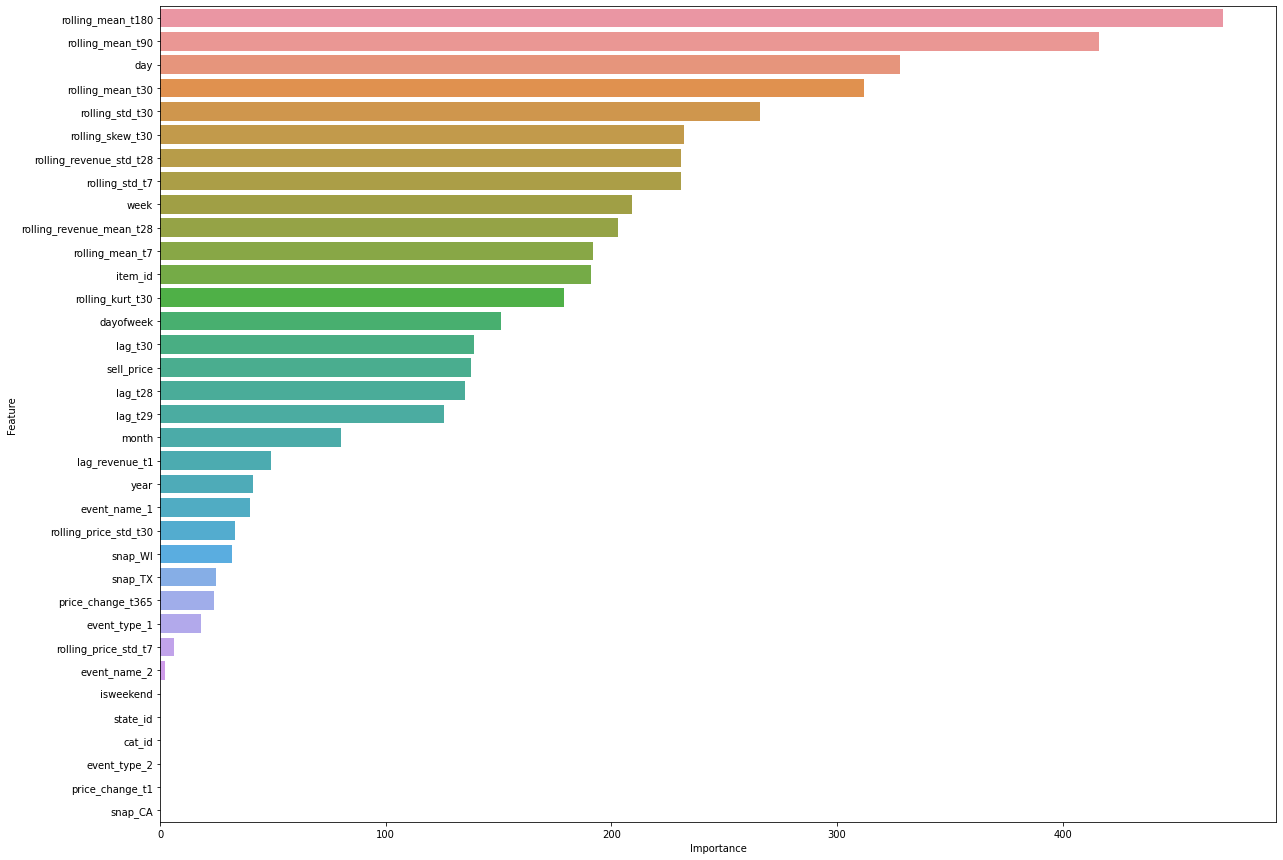

In [50]:
# Feature importance 
importance = model.feature_importance()
feature_imp = pd.DataFrame(list(zip(features, importance)), columns=['Feature', 'Importance'])
feature_imp = feature_imp.sort_values(by='Importance', ascending=False)
import seaborn as sns
plt.figure(figsize=(20,15))
sns.barplot(x='Importance', y='Feature', data=feature_imp)



Shapely Importance

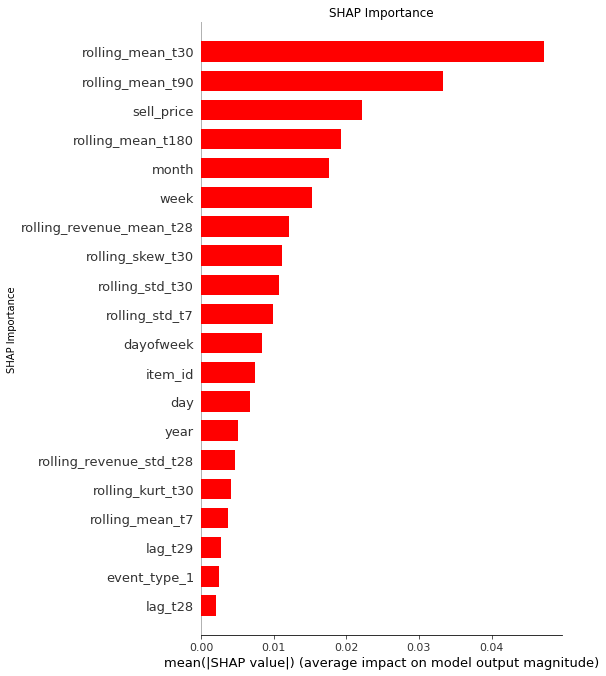

In [51]:
# Shapley Importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_t[features])
plt.figure(figsize=(20, 15))
plt.title('SHAP Importance')
plt.xlabel('Feature')
plt.ylabel('SHAP Importance')
shap.summary_plot(shap_values, x_t[features], plot_type="bar", color='red')


Concat Predictions

In [52]:
predictions1 = TEST[TEST['id'].apply(lambda x: "validation" in x)][['id', 'date', 'demand']]
predictions2 = TEST[TEST['id'].apply(lambda x: "evaluation" in x)][['id', 'date', 'demand']]

In [53]:
prediction1 = pd.pivot(predictions1, index = 'id', columns = 'date', values = 'demand').reset_index()
prediction2 = pd.pivot(predictions2, index = 'id', columns = 'date', values = 'demand').reset_index()
prediction1.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
prediction2.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [54]:
predictions = pd.concat([prediction1,prediction2],axis=0)
predictions.to_csv("submissions_lgb.csv",index=False)

### XGBoost

Features

In [55]:
### Full Features
features = ['item_id', 'cat_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'rolling_skew_t30', 'rolling_kurt_t30',
            'isweekend','lag_revenue_t1','rolling_revenue_std_t28','rolling_revenue_mean_t28'
        ]
### Fitltered Features
#features = ['item_id', 'cat_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
#            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
#            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'rolling_skew_t30', 'rolling_kurt_t30',
#            'isweekend','lag_revenue_t1','rolling_revenue_std_t28','rolling_revenue_mean_t28'
#        ]

Train-Val-Test X/Y Split

In [56]:
# Train Data
x_train = data[data['part'] == 'train']
y_train = x_train['demand']
x_train.drop(['demand','part',],inplace=True,axis=1)

# Validation Data
x_val = data[(data['date'] > '2016-04-24') & (data['part'] == 'train')]
y_val = x_val['demand']
x_val.drop(['demand','part',],inplace=True,axis=1)

# Test Data
test = data[data['date'] > '2016-04-24']
test.loc[test['part']=='train','id'] = test.loc[test['part']=='train','id'].str.replace('_evaluation','_validation')
test.drop(['demand','part',],inplace=True,axis=1)

In [57]:
# Clear Memory
### del data
gc.collect()

4752

Parameters

In [58]:
# Define the XGBoost regressor
regressor = xgb.XGBRegressor()
params = {'booster': 'gbtree',
          'objective': 'reg:squarederror',
          'max_depth': 3,
          'eta': 0.1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'alpha': 0.1,
          'lambda': 1}

Dataset Restructure for Multi-Step 

In [59]:
# Coding dataset function to fit into DMatrix() matrix from Xgboost
category = x_train['dept_id'].unique()
category2 = x_train['store_id'].unique()

def dataset(categor,categor2):
    tindex = x_train[(x_train['dept_id']==categor) & (x_train['store_id']==categor2)].index.values
    vindex = x_val[(x_val['dept_id']==categor)&(x_val['store_id']==categor2)].index.values
    
    x_t,x_v,y_t,y_v,t =  x_train[(x_train['dept_id']==categor) & (x_train['store_id']==categor2)],x_val[(x_val['dept_id']==categor)&(x_val['store_id']==categor2)],y_train.loc[tindex],y_val.loc[vindex],test[(test['dept_id']==categor) &(test['store_id']==categor2)]
    
    x_train.drop(tindex,axis=0,inplace=True)
    x_val.drop(vindex,axis=0,inplace=True)
    test.drop(test[(test['dept_id']==categor) &(test['store_id']==categor2)].index.values,axis=0,inplace=True)
    
    return x_t,x_v,y_t,y_v,t

Model

In [60]:
TEST = None

#XGBoost Model
for i in category:
    for j in category2:
        x_t,x_v,y_t,y_v,t = dataset(i,j)
        train_set = xgb.DMatrix(x_t[features], y_t)
        val_set = xgb.DMatrix(x_v[features], y_v)
        gc.collect()
        model = xgb.train(params, dtrain=train_set, num_boost_round = 150, early_stopping_rounds = 40, evals=[(train_set, "train"), (val_set, "val")], verbose_eval = 1000)
        y_pred = model.predict(xgb.DMatrix(t[features]))
        t['demand'] = y_pred
        TEST = pd.concat([TEST,t],axis=0)
        gc.collect()

[0]	train-rmse:2.15813	val-rmse:2.27496
[149]	train-rmse:1.51370	val-rmse:1.58150
[0]	train-rmse:2.30423	val-rmse:2.35108
[149]	train-rmse:1.62702	val-rmse:1.63303
[0]	train-rmse:2.16003	val-rmse:2.44171
[149]	train-rmse:1.58593	val-rmse:1.71425
[0]	train-rmse:4.75656	val-rmse:4.36248
[62]	train-rmse:2.89715	val-rmse:2.77969
[0]	train-rmse:1.12891	val-rmse:1.30869
[149]	train-rmse:0.97264	val-rmse:1.10659
[0]	train-rmse:2.58300	val-rmse:2.49849
[149]	train-rmse:1.80666	val-rmse:1.64203
[0]	train-rmse:3.03901	val-rmse:2.57493
[93]	train-rmse:2.10711	val-rmse:1.79526
[0]	train-rmse:2.73306	val-rmse:2.62535
[149]	train-rmse:1.83333	val-rmse:1.77473
[0]	train-rmse:1.69601	val-rmse:1.81236
[149]	train-rmse:1.30677	val-rmse:1.38180
[0]	train-rmse:3.20538	val-rmse:3.62853
[149]	train-rmse:2.05205	val-rmse:2.05877
[0]	train-rmse:0.66340	val-rmse:0.86037
[149]	train-rmse:0.53803	val-rmse:0.65552
[0]	train-rmse:0.82529	val-rmse:0.85078
[149]	train-rmse:0.73936	val-rmse:0.76342
[0]	train-rmse:1.0

Feature Importance

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

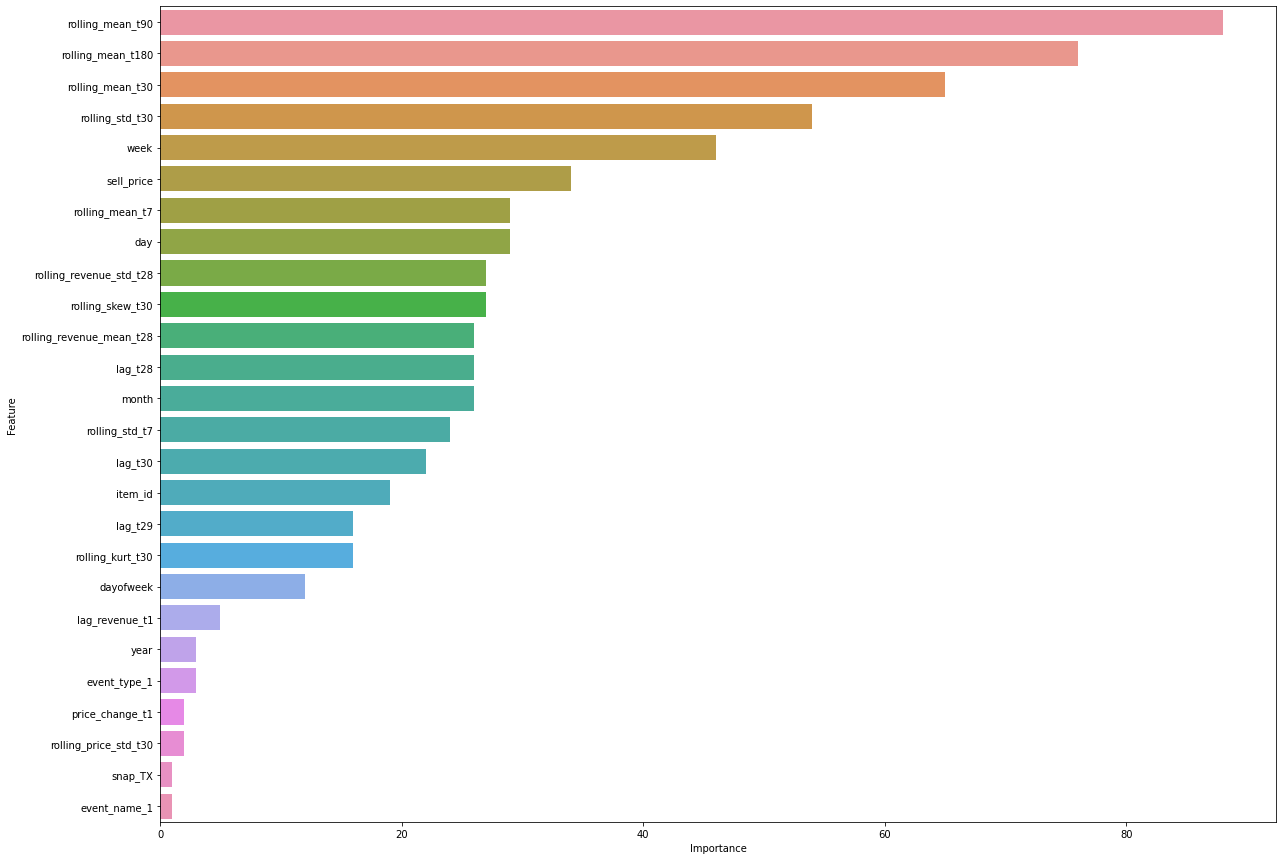

In [61]:

# Feature importance for xgboost
importance = model.get_score(importance_type='weight')
feature_imp = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
feature_imp = feature_imp.sort_values(by='Importance', ascending=False)
import seaborn as sns
plt.figure(figsize=(20,15))
sns.barplot(x='Importance', y='Feature', data=feature_imp)



Shapely Importance

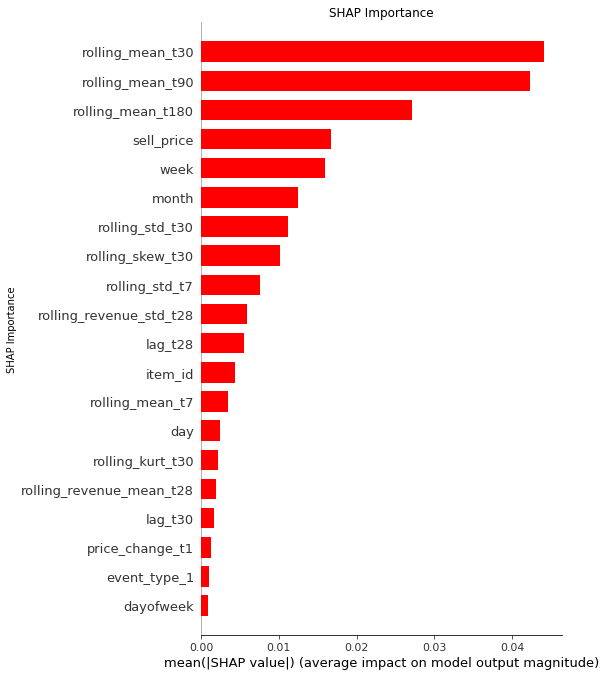

In [62]:
# Shapley Importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_t[features])
plt.figure(figsize=(20, 15))
plt.title('SHAP Importance')
plt.xlabel('Feature')
plt.ylabel('SHAP Importance')
shap.summary_plot(shap_values, x_t[features], plot_type="bar", color='red')



Concat Results

In [63]:
predictions1 = TEST[TEST['id'].apply(lambda x: "validation" in x)][['id', 'date', 'demand']]
predictions2 = TEST[TEST['id'].apply(lambda x: "evaluation" in x)][['id', 'date', 'demand']]

In [64]:
prediction1 = pd.pivot(predictions1, index = 'id', columns = 'date', values = 'demand').reset_index()
prediction2 = pd.pivot(predictions2, index = 'id', columns = 'date', values = 'demand').reset_index()
prediction1.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
prediction2.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [65]:
predictions = pd.concat([prediction1,prediction2],axis=0)
predictions.to_csv("submission_xgb.csv",index=False)